## Time Series Analysis

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing Data
#### 6. Export Files

### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.
warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

In [2]:
path = r'C:\Users\Nuno\05-2024 AirBnB Amsterdam Analysis\02 Data'
calendar_df=pd.read_csv(os.path.join(path,'Original Data','calendar.csv'),index_col=None)

### 2. Subsetting, wrangling, and cleaning time-series data

In [3]:
#Checking import
calendar_df.head()

,listing_id,date,available,price
0,2818,2019-12-05,f,NaN
1,73208,2019-08-30,f,NaN
2,73208,2019-08-29,f,NaN
3,73208,2019-08-28,f,NaN
4,73208,2019-08-27,f,NaN


In [4]:
#Understanding size of dataset
calendar_df.shape

(7310950, 4)

#### Type Enforcement

In [5]:
#printing out variable types
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [6]:
# changing date type to datetime and id to an object
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['listing_id'] = calendar_df['listing_id'].astype('str')
# Convert 'price' to a consistent numeric format if it's not already (e.g., remove currency symbols and convert to float)
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)

In [7]:
# Checking type changes
calendar_df.dtypes

listing_id            object
date          datetime64[ns]
available             object
price                float64
dtype: object

#### Checking for Duplicates

In [8]:
dups = calendar_df.duplicated()
dups.shape

(7310950,)

##### There are no Duplicate values in the dataset

#### Missing Values

In [9]:
calendar_df.isnull().sum()

listing_id          0
date                0
available           0
price         6110879
dtype: int64

In [10]:
#Assessing if the NaN prices match up with the entries where the listings are not available
null_prices_df = calendar_df[calendar_df['price'].isnull()]

In [11]:
null_prices_df['available'].value_counts()

available
f    6110879
Name: count, dtype: int64

In [12]:
# Group by 'listing_id' and aggregate to find the number of unique prices for each listing
unique_price_counts = calendar_df.groupby('listing_id')['price'].nunique()

# Check listings with exactly one unique price
single_price_listings = unique_price_counts[unique_price_counts == 1]

# Check listings with more than one unique price
variable_price_listings = unique_price_counts[unique_price_counts > 1]

# Output results
print(f"Listings with a single unique price: {len(single_price_listings)}")
print(f"Listings with variable prices: {len(variable_price_listings)}")

# Optional: Display the count of unique prices for listings that have variable prices
if len(variable_price_listings) > 0:
    print("Listings with more than one unique price:\n", variable_price_listings)

Listings with a single unique price: 3769
Listings with variable prices: 6917
Listings with more than one unique price:
 listing_id
10008030     2
10015614    16
10025641     8
10026487     2
10031824     3
            ..
998139       2
9985691      5
998754       4
998822       3
9989934      4
Name: price, Length: 6917, dtype: int64


In [13]:
# Set display option to suppress scientific notation, using a lambda to format floats
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#Describing values of dataset
calendar_df.describe()

,date,price
count,7310950,1200071.00
mean,2019-06-06 01:00:53.559662336,207.66
min,2018-12-06 00:00:00,9.00
25%,2019-03-07 00:00:00,109.00
50%,2019-06-06 00:00:00,150.00
75%,2019-09-05 00:00:00,240.00
max,2019-12-06 00:00:00,8500.00
std,NaN,281.24


In [14]:
# Group by 'listing_id' and forward fill NaN values in 'price', then backward fill
# Using transform to ensure the index is maintained
calendar_df['price'] = calendar_df.groupby('listing_id')['price'].transform(lambda x: x.ffill().bfill())
print(calendar_df)

        listing_id       date available  price
0             2818 2019-12-05         f  59.00
1            73208 2019-08-30         f 220.00
2            73208 2019-08-29         f 220.00
3            73208 2019-08-28         f 220.00
4            73208 2019-08-27         f 220.00
...            ...        ...       ...    ...
7310945   29979667 2018-12-11         t 139.00
7310946   29979667 2018-12-10         t 139.00
7310947   29979667 2018-12-09         t 139.00
7310948   29979667 2018-12-08         t 139.00
7310949   29979667 2018-12-07         t 139.00

[7310950 rows x 4 columns]


In [15]:
calendar_df.isnull().sum()

listing_id          0
date                0
available           0
price         3410560
dtype: int64

In [16]:
6110879/3410560

1.791752380840683

We can see that even after forwardfilling and backfilling price values in the dataframe, we still have roughly half of the NaN values.We will fill the rest with the median of the dataset to be less affected by outlier prices.

In [17]:
default_price = calendar_df['price'].dropna().median()
calendar_df['price'].fillna(default_price,inplace=True)

In [18]:
#Checking nulls
calendar_df.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [19]:
calendar_df.describe()

,date,price
count,7310950,7310950.00
mean,2019-06-06 01:00:53.559662336,165.63
min,2018-12-06 00:00:00,9.00
25%,2019-03-07 00:00:00,140.00
50%,2019-06-06 00:00:00,149.00
75%,2019-09-05 00:00:00,150.00
max,2019-12-06 00:00:00,8500.00
std,NaN,134.72


#### Checking for Outliers

<Axes: xlabel='price', ylabel='Count'>

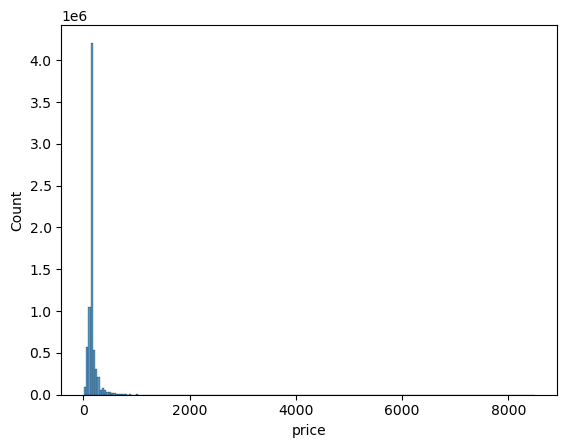

In [20]:
# Looking for outliers in price
sns.histplot(calendar_df['price'], bins= 200)

<Axes: ylabel='Count'>

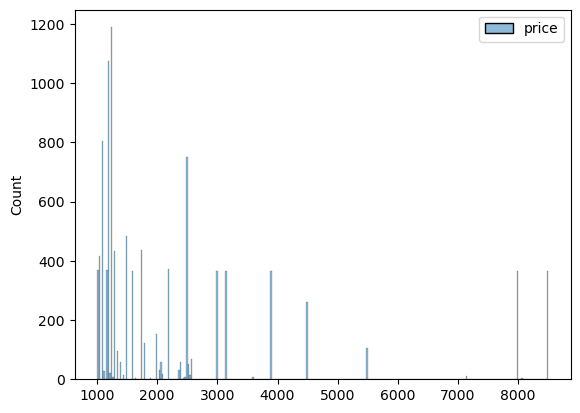

In [21]:
# looking for outliers in price
sns.histplot(calendar_df[calendar_df['price']> 1000], bins = 300)

We can consider that all the points above the 3000 are likely outliers or mistakes in entering the price, as there is not likely to be a listing with a daily price of over 3000$

In [22]:
#Percentage of outliers
(len(calendar_df[(calendar_df['price']>3000)])/len(calendar_df))*100

0.025290830876972214

##### Since the percentage of outliers is so small, we can safely drop them from the dataset

In [23]:
calendar_df = calendar_df[(calendar_df['price']<3000)]

In [24]:
calendar_df.shape

(7308736, 4)

#### Wrangling

In [25]:
calendar_df['available'].value_counts()

available
f    6110350
t    1198386
Name: count, dtype: int64

In [26]:
calendar_df.loc[calendar_df['available'] == 'f', 'availability_count_flag'] = 0
calendar_df.loc[calendar_df['available'] == 't', 'availability_count_flag'] = 1

In [27]:
calendar_df['availability_count_flag'].value_counts()

availability_count_flag
0.00    6110350
1.00    1198386
Name: count, dtype: int64

In [28]:
calendar_df.head()

,listing_id,date,available,price,availability_count_flag
0,2818,2019-12-05,f,59.00,0.00
1,73208,2019-08-30,f,220.00,0.00
2,73208,2019-08-29,f,220.00,0.00
3,73208,2019-08-28,f,220.00,0.00
4,73208,2019-08-27,f,220.00,0.00


In [29]:
calendar_df.drop(columns='available',inplace= True)

In [30]:
calendar_df.head()

,listing_id,date,price,availability_count_flag
0,2818,2019-12-05,59.00,0.00
1,73208,2019-08-30,220.00,0.00
2,73208,2019-08-29,220.00,0.00
3,73208,2019-08-28,220.00,0.00
4,73208,2019-08-27,220.00,0.00


#### Create Subsets & Initial Plot Lines

In [31]:
#price
sub_price = calendar_df[['date','price']]
#Availability
sub_availability = calendar_df[['date','availability_count_flag']]

In [32]:
#Create average price grouped by mean
sub_grouped_price = sub_price.groupby('date').mean()

In [33]:
sub_grouped_price.head()

,price
date,
2018-12-06,160.64
2018-12-07,159.31
2018-12-08,159.28
2018-12-09,158.82
2018-12-10,158.83


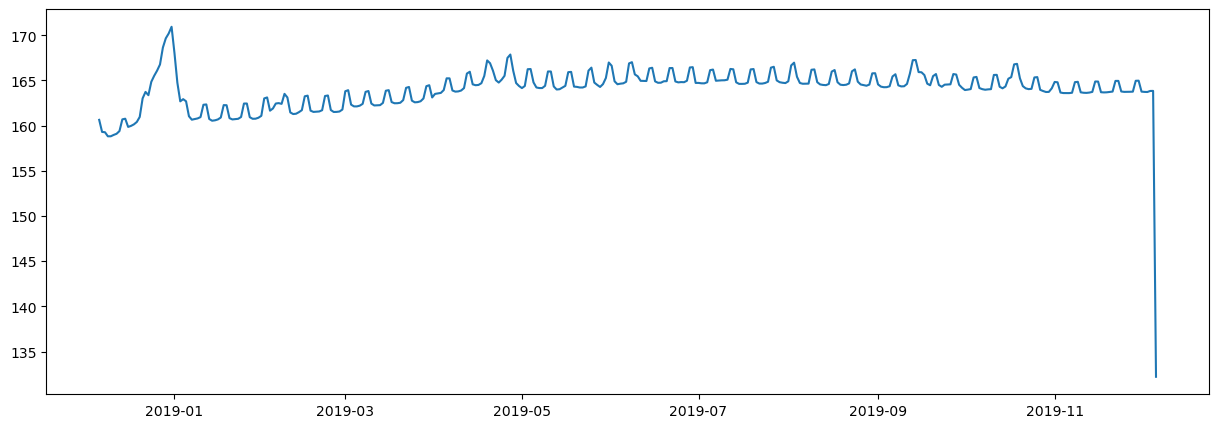

In [34]:
# Plot the new price time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub_grouped_price)

In [35]:
# Find the minimum in column 'price'
min_value_grouped_price = sub_grouped_price['price'].min()

# Drop rows where column 'price' is equal to the minimum
sub_grouped_price = sub_grouped_price[sub_grouped_price['price'] != min_value_grouped_price]


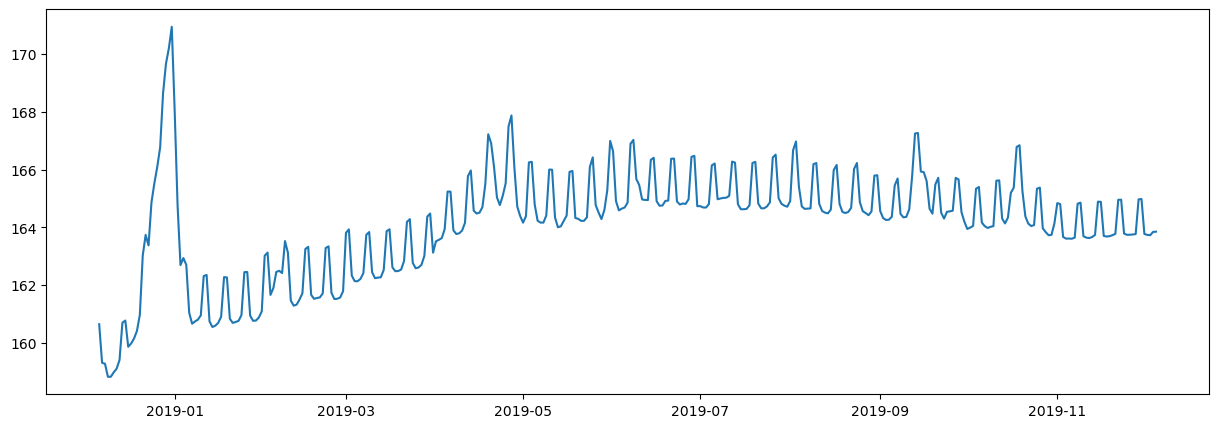

In [36]:
# Plot the new price time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub_grouped_price)

In [37]:
sub_grouped_availability = sub_availability.groupby('date').sum()

In [38]:
sub_grouped_availability.head()

,availability_count_flag
date,
2018-12-06,1186.00
2018-12-07,1421.00
2018-12-08,1719.00
2018-12-09,2871.00
2018-12-10,3307.00


In [39]:
len(sub_availability)

7308736

In [40]:
sub_availability['availability_count_flag'].value_counts()

availability_count_flag
0.00    6110350
1.00    1198386
Name: count, dtype: int64

In [41]:
sub_grouped_availability.value_counts()

availability_count_flag
3056.00                    4
3088.00                    4
3068.00                    4
2871.00                    4
3073.00                    3
                          ..
3030.00                    1
3032.00                    1
3033.00                    1
3035.00                    1
4817.00                    1
Name: count, Length: 301, dtype: int64

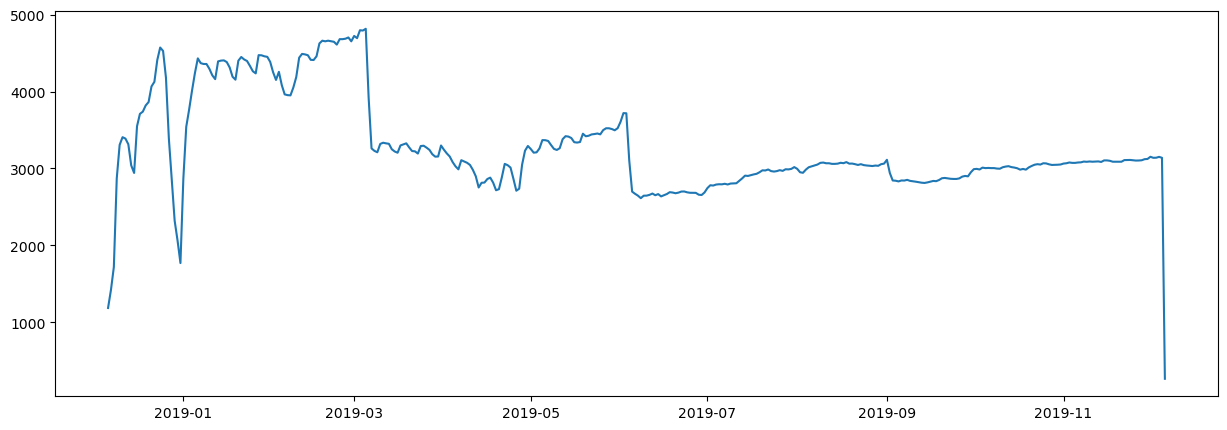

In [42]:
# Plot the new availability time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub_grouped_availability)

In [43]:
# Find the minimum in column 'availability_count_flag'
min_value_grouped_availability = sub_grouped_availability['availability_count_flag'].min()

# Drop rows where column 'availability_count_flag' is equal to the minimum
sub_grouped_availability = sub_grouped_availability[sub_grouped_availability['availability_count_flag'] != min_value_grouped_availability]

In [45]:
sub_grouped_availability.head()

,availability_count_flag
date,
2018-12-06,1186.00
2018-12-07,1421.00
2018-12-08,1719.00
2018-12-09,2871.00
2018-12-10,3307.00


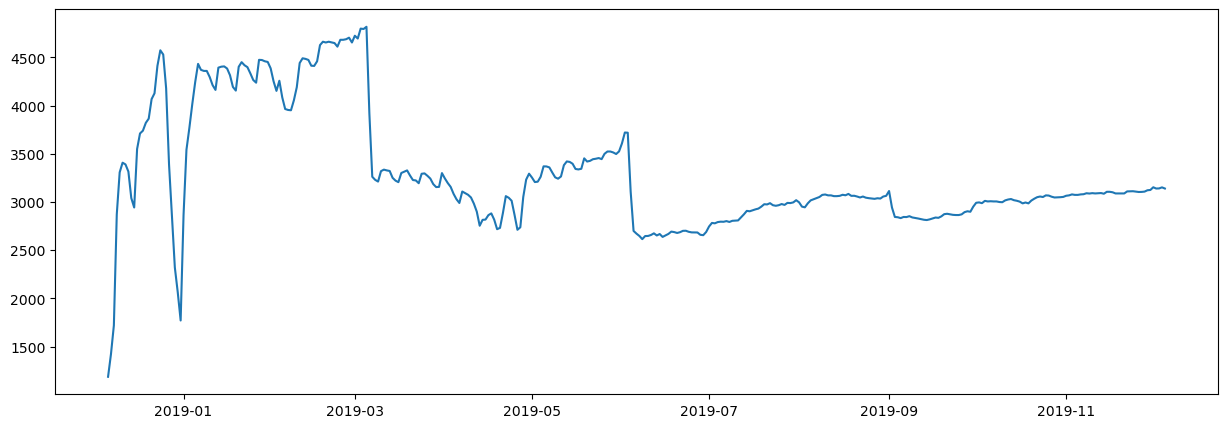

In [44]:
# Plot the new availability time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub_grouped_availability)

### 3. Time-series analysis: decomposition

##### Price

In [45]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(sub_grouped_price, model='additive')

In [46]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

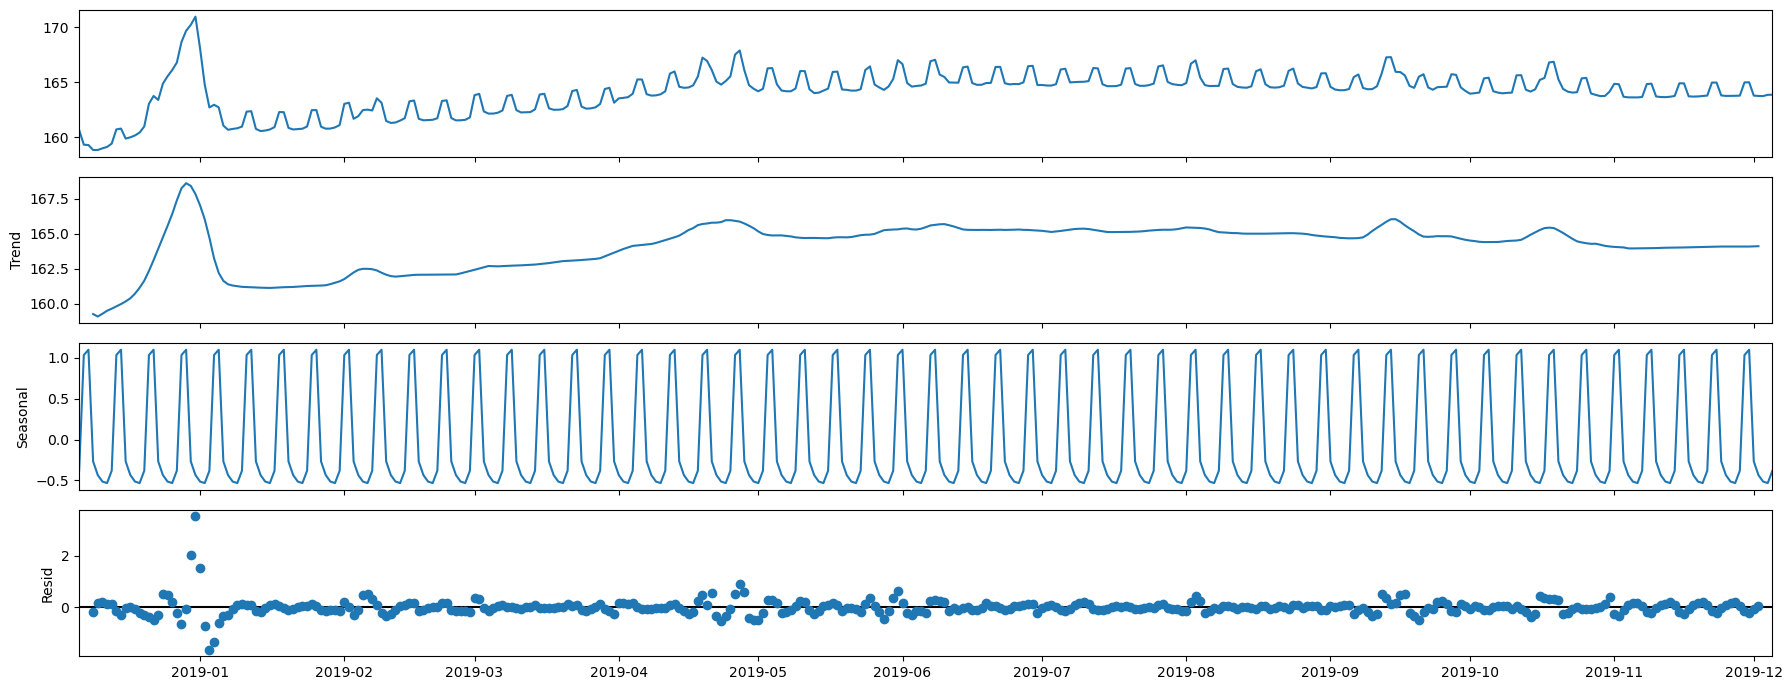

In [47]:
# Plot the separate components

decomposition.plot()
plt.show()

##### Availability

In [48]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(sub_grouped_availability, model='additive')

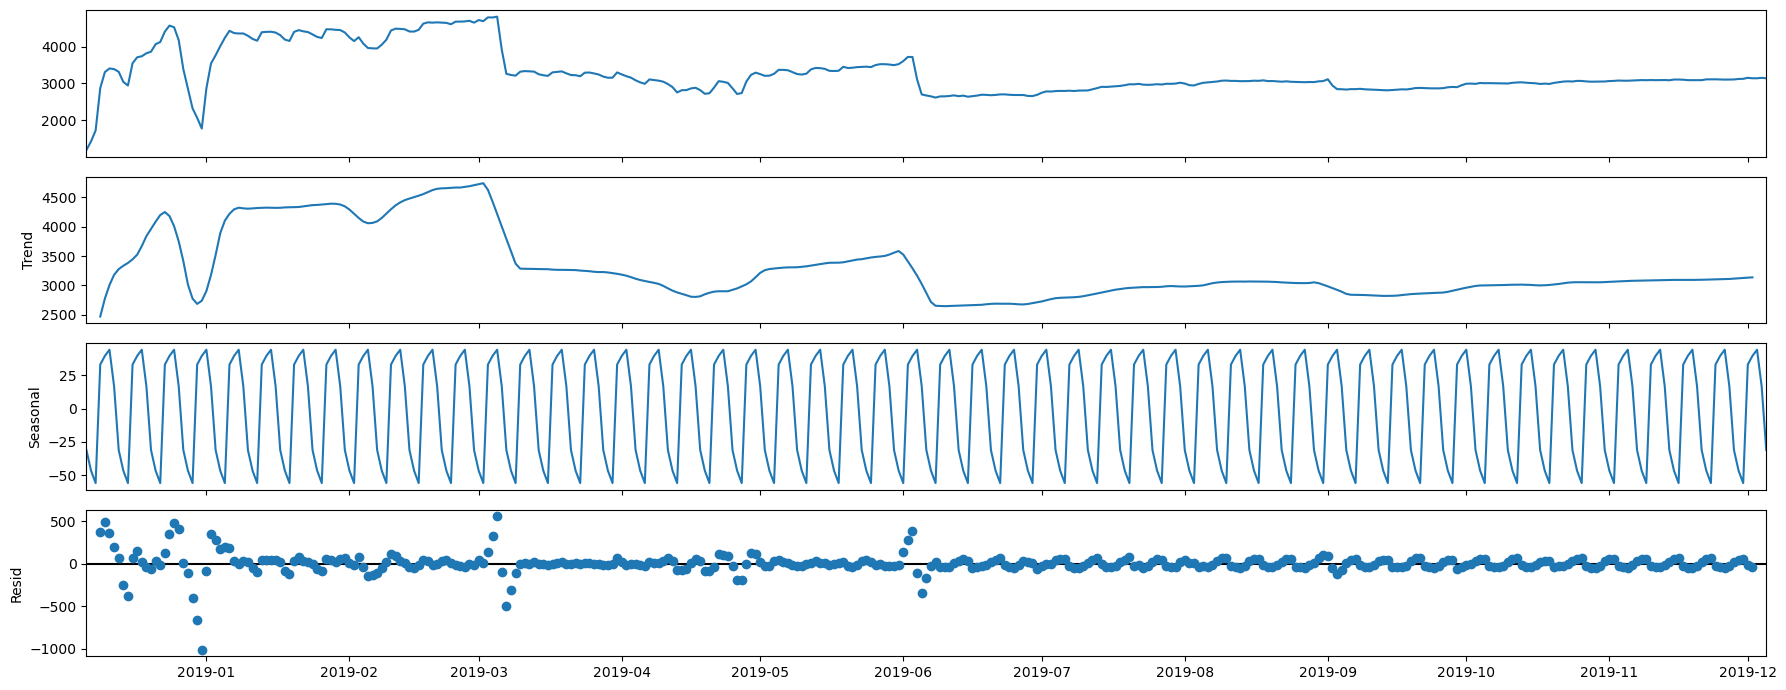

In [49]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

##### Price

In [50]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function that will print the results of the dickey_fuller test
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(sub_grouped_price)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.96
p-value                         0.04
Number of Lags Used            15.00
Number of Observations Used   349.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


The data is stationary for significance levels below 5%, but for 5% we can already consider this a stationary datset, as the test statistic is smaler than the Critical Value(5%), and the p<0.05. However, let's assess the level of auto-correlation before understanding if the data can already be used for time series forecasting

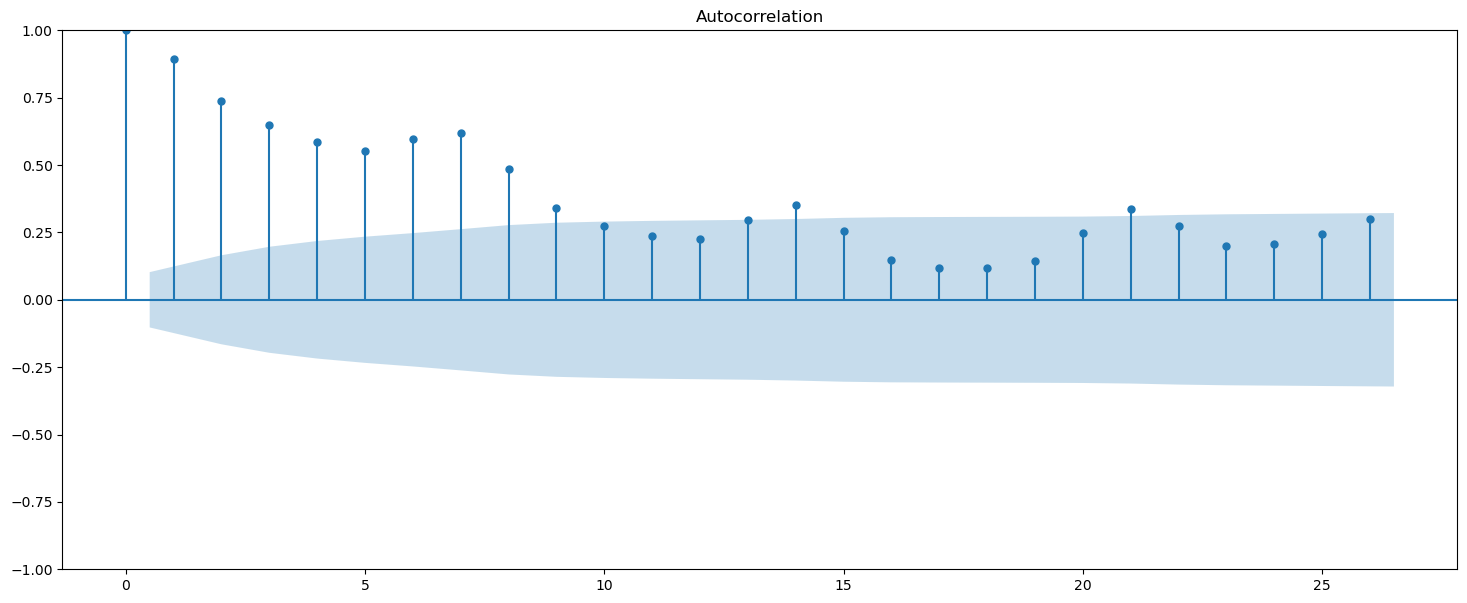

In [51]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(sub_grouped_price)
plt.show()

While the Dickey-Fuller test shows non-stationarity for significance levels of 5% and above, there is still a relative degree of auto-correlation.

##### Availability

In [52]:
# Apply the test using the function on the time series
dickey_fuller(sub_grouped_availability)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.59
p-value                         0.49
Number of Lags Used            17.00
Number of Observations Used   347.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


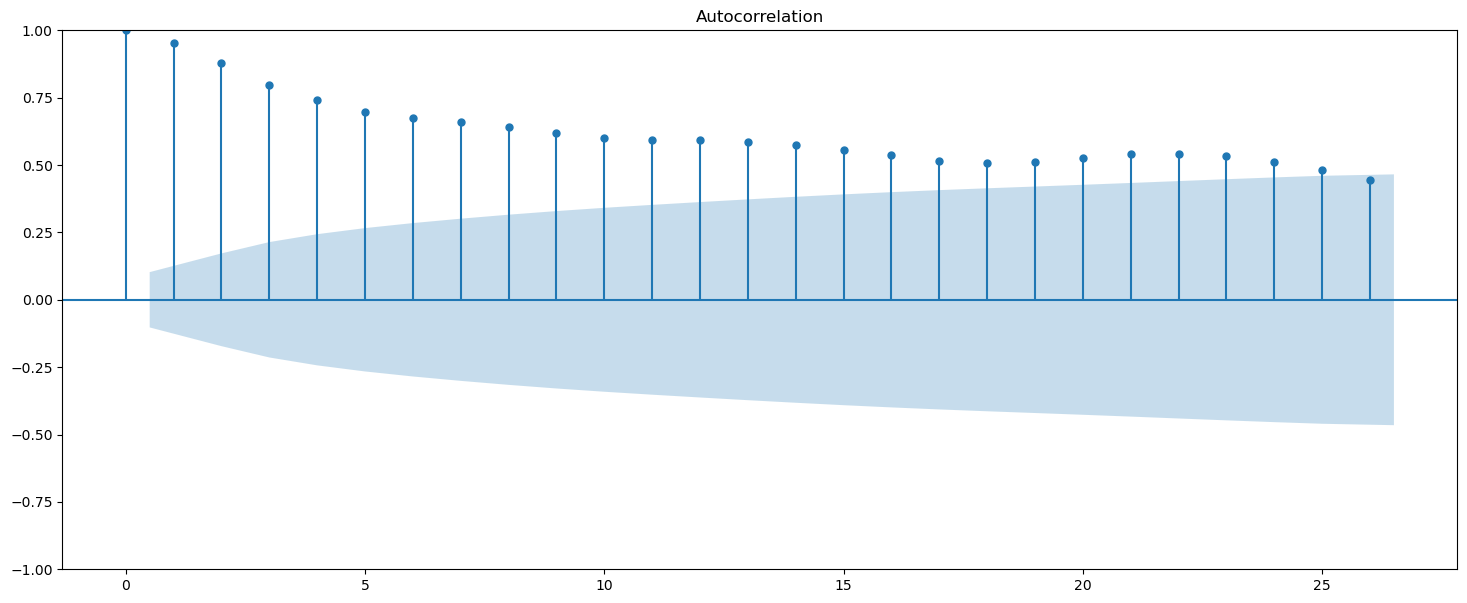

In [53]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(sub_grouped_availability)
plt.show()

The data is non-stationary for all observed significance levels, as the test statistic is larger than all shown Critical Values(5%). Additionally, the data is highly autocorrelated. Therefore, we will have to Stationarize this data for time series forecasting.

### 5. Stationarizing Data

##### Availability

In [69]:
data_diff_availability = sub_grouped_availability - sub_grouped_availability.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [70]:
data_diff_availability.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 

In [72]:
dickey_fuller(data_diff_availability)

Dickey-Fuller Stationarity test:
Test Statistic                 -7.61
p-value                         0.00
Number of Lags Used            17.00
Number of Observations Used   346.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


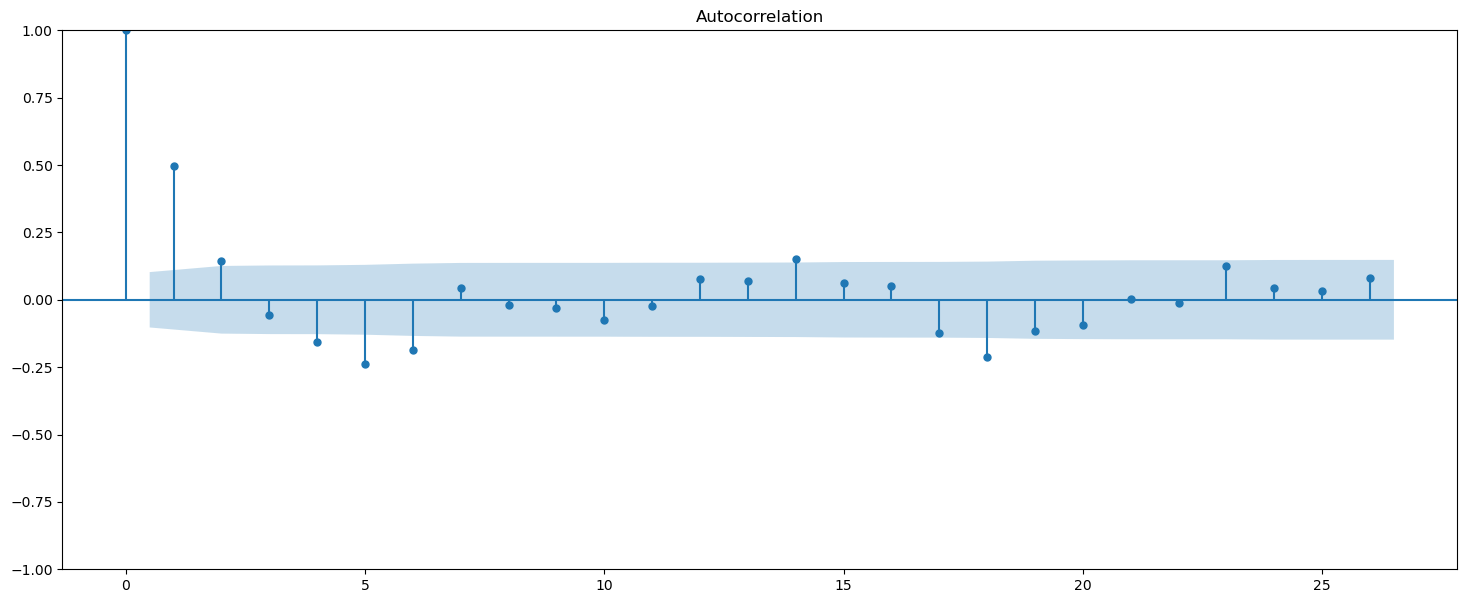

In [74]:
#Plot the autocorrelations
plot_acf(data_diff_availability)
plt.show()

The data is now stationary at all shown confidence levels, and shows a small degree of autocorrelation.

### 6. Export Files

In [47]:
sub_grouped_availability.to_csv(os.path.join(path,'Prepared Data','time_series_availability.csv'))
sub_grouped_price.to_csv(os.path.join(path,'Prepared Data','time_series_price.csv'))